# Goal

__Question:__ how is incorporator identification accuracy affected by the percent isotope incorporation of taxa?

* Using genome dataset created in the "dataset" notebook

* Simulates isotope dilution or short incubations
  * Method  
    * 25% taxa incorporate
    * incorporation % same for all incorporators
    * incorporation % treatments: 10, 20, 40, 60, 80, 100%
    * Total treatments: 6
* ALSO, testing the use of differing BD ranges on sensitivity/specificity

# User variables

In [174]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [175]:
import glob
import itertools
from os.path import abspath
import nestly

In [176]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [177]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

# Using nestly: different incorporation percentages

In [178]:
# building tree structure
nest = nestly.Nest()

## varying params
### perc incorporation
nest.add('percIncorp', range(0,101,20))
### BD range
BD_min = np.arange(1.67, 1.77, 0.02).tolist()
BD_max = [x + 0.04 for x in BD_min]
f = lambda x: {'BD_range': str(x[0]) + '-' + str(x[1]), 
               'BD_min':x[0], 
               'BD_max':x[1]}
BD_range = [f(x) for x in itertools.product(BD_min, BD_max) 
            if x[0] < x[1]]
#### contains BD_min & BD_max
nest.add('BD_range', BD_range, update=True)

## set params
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
#nest.add('fileName', ['ampFrags'], create_dir=False)
nest.add('perc_incorp_dir', ['/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/'], create_dir=False)
nest.add('otu_file', ['OTU_n2_abs1e10_sub-norm_w.txt'], create_dir=False)
nest.add('otu_metadata', ['OTU_n2_abs1e10_sub-norm_meta.txt'], create_dir=False)
nest.add('BD_shift', ['ampFrags_kde_dif_incorp_BD-shift.txt'], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
buildDir = os.path.join(workDir, 'percIncorpUnif_difBD')
nest.build(buildDir)

In [179]:
bashFile = os.path.join(workDir, 'SIPSimRun.sh')

In [180]:
%%writefile $bashFile
#!/bin/bash

# copying files from perc_incorp_unif
cp {perc_incorp_dir}{percIncorp}/{otu_file} .
cp {perc_incorp_dir}{percIncorp}/{otu_metadata} .
cp {perc_incorp_dir}{percIncorp}/{BD_shift} .
  
#-- R analysis --#
export PATH={R_dir}:$PATH
# running DeSeq2 and making confusion matrix on predicting incorporators
## making phyloseq object from OTU table
phyloseq_make.r \
    {otu_file} \
    -s {otu_metadata} \
    > {otu_file}.physeq

## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    {otu_file}.physeq \
    --BD_min {BD_min} --BD_max {BD_max} \
    > {otu_file}_filt.physeq
## making ordination
phyloseq_ordination.r \
    --log2 {log2} \
    --hypo greater \
    {otu_file}_filt.physeq \
    {otu_file}_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    {otu_file}_filt.physeq \
    > {otu_file}_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {BD_shift} \
    {otu_file}_DESeq2 \
    --padj {padj}    
          

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/SIPSimRun.sh


In [181]:
!chmod 775 $bashFile

In [182]:
!cd $workDir; \
    nestrun -j 30 --template-file $bashFile -d percIncorpUnif_difBD --log-file log.txt

2015-07-17 10:57:08,940 * INFO * Template: ./SIPSimRun.sh
2015-07-17 10:57:08,942 * INFO * [25676] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.67-1.79
2015-07-17 10:57:08,944 * INFO * [25677] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.73-1.77
2015-07-17 10:57:08,947 * INFO * [25680] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.69-1.77
2015-07-17 10:57:08,950 * INFO * [25684] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.71-1.75
2015-07-17 10:57:08,953 * INFO * [25688] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.75-1.81
2015-07-17 10:57:08,955 * INFO * [25693] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.71-1.73
2015-07-17 10:57:08,957 * INFO * [25700] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.73-1.79
2015-07-17 10:57:08,959 * INFO * [25705] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.69-1.71
2015-07-17 10:57:08,961 * INFO * [25719] Started ./SIPSimRun.sh in percIncorpUnif_difBD/80/1.77-1.81
2015-07-17 10:57:08,963 * INFO * 

In [183]:
# aggregating confusion matrix data
## table
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnif_difBD \
        -k percIncorp,BD_min,BD_max \
        -o ./percIncorpUnif_difBD/DESeq2-cMtx_table.csv \
        DESeq2-cMtx_table.csv

## overall
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnif_difBD \
        -k percIncorp,BD_min,BD_max \
        -o ./percIncorpUnif_difBD/DESeq2-cMtx_overall.csv \
        DESeq2-cMtx_overall.csv
    
## byClass
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnif_difBD \
        -k percIncorp,BD_min,BD_max \
        -o ./percIncorpUnif_difBD/DESeq2-cMtx_byClass.csv \
        DESeq2-cMtx_byClass.csv

### Plotting results

In [184]:
%%R -i workDir -w 600 -h 600
setwd(workDir)

byClass = read.csv('./percIncorpUnif_difBD/DESeq2-cMtx_byClass.csv')

byClass$byClass[is.na(byClass$byClass)] = 0

cat.str = function(x,y, col=':'){
    x = as.character(x)
    y = as.character(y)
    z = paste(c(x,y),collapse=col)
    return(z)
    }

byClass = byClass %>% 
    mutate(BD_range = mapply(cat.str, BD_min, BD_max)) %>%
    mutate(BD_min = as.character(BD_min),
           BD_max = as.character(BD_max)) 

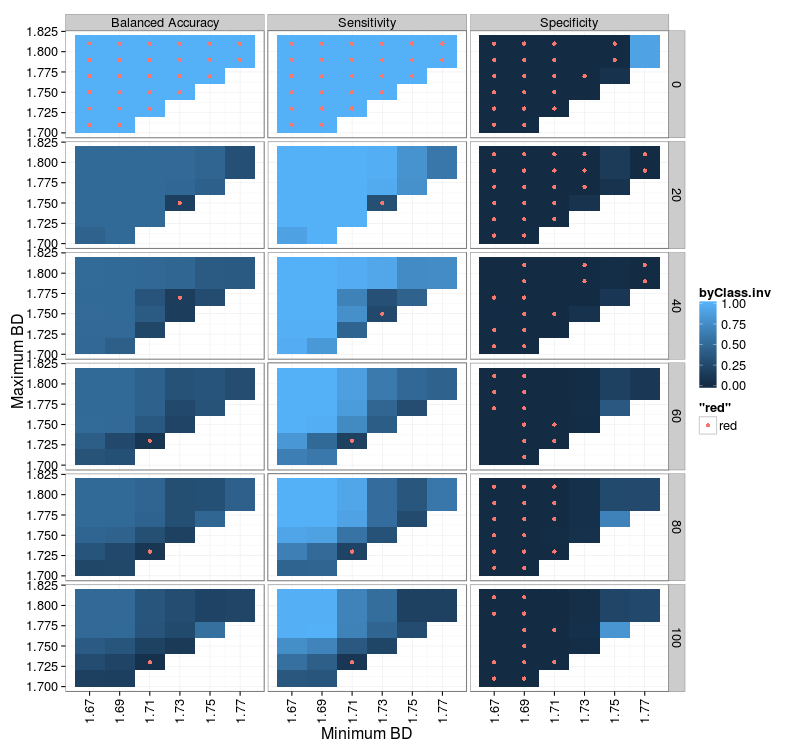

In [185]:
%%R -w 800 -h 750

col2keep = c('Balanced Accuracy', 'Sensitivity','Specificity')
byClass.f = byClass %>%
    filter(X %in% col2keep) %>%
    mutate(BD_min = as.numeric(BD_min),
           BD_max = as.numeric(BD_max),
           byClass = as.numeric(byClass),
           byClass.inv = 1 - byClass) 

byClass.fs = byClass.f %>%
    group_by(X, percIncorp) %>%
    summarize(byClass.max = max(byClass))

just.true = function(x){
    if(x == TRUE){
        return(1)
        } else{
        return(NA)
        }
    }

byClass.j = inner_join(byClass.f, byClass.fs, c('X' = 'X',
                                                'percIncorp' = 'percIncorp')) %>%
    mutate(max_val = as.numeric(byClass == byClass.max))
byClass.jf = byClass.j %>%
    filter(max_val == 1)

x.breaks = unique(byClass.j$BD_min)

p = ggplot(byClass.j, aes(BD_min, BD_max, fill=byClass.inv)) +
    geom_tile() +
    geom_point(data=byClass.jf, aes(color='red')) +
    scale_x_continuous(breaks=x.breaks) +
    labs(x='Minimum BD', y='Maximum BD') +
    facet_grid(percIncorp ~ X) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)
        )
p

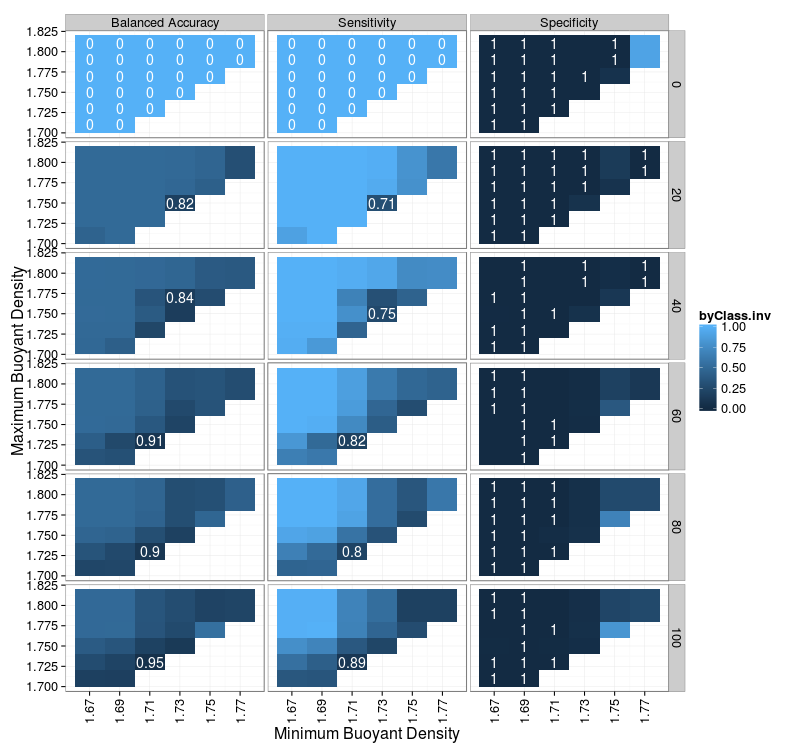

In [186]:
%%R -w 800 -h 750

col2keep = c('Balanced Accuracy', 'Sensitivity','Specificity')
byClass.f = byClass %>%
    filter(X %in% col2keep) %>%
    mutate(BD_min = as.numeric(BD_min),
           BD_max = as.numeric(BD_max),
           byClass = as.numeric(byClass),
           byClass.inv = 1 - byClass) 

byClass.fs = byClass.f %>%
    group_by(X, percIncorp) %>%
    summarize(byClass.max = max(byClass))

just.true = function(x){
    if(x == TRUE){
        return(1)
        } else{
        return(NA)
        }
    }

byClass.j = inner_join(byClass.f, byClass.fs, c('X' = 'X',
                                                'percIncorp' = 'percIncorp')) %>%
    mutate(max_val = as.numeric(byClass == byClass.max),
           byClass.txt = round(byClass, 2))
byClass.jf = byClass.j %>%
    filter(max_val == 1)

x.breaks = unique(byClass.j$BD_min)

p = ggplot(byClass.j, aes(BD_min, BD_max, fill=byClass.inv)) +
    geom_tile() +
    geom_text(data=byClass.jf, aes(label=byClass.txt), color=c('white')) +
    scale_x_continuous(breaks=x.breaks) +
    labs(x='Minimum Buoyant Density', y='Maximum Buoyant Density') +
    facet_grid(percIncorp ~ X) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)
        )
p

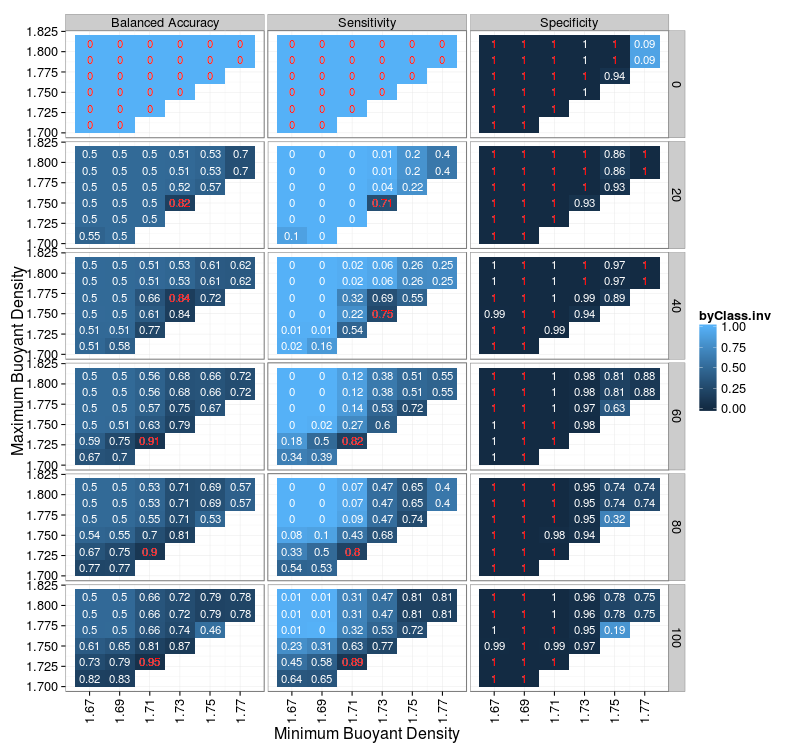

In [187]:
%%R -w 800 -h 750

col2keep = c('Balanced Accuracy', 'Sensitivity','Specificity')
byClass.f = byClass %>%
    filter(X %in% col2keep) %>%
    mutate(BD_min = as.numeric(BD_min),
           BD_max = as.numeric(BD_max),
           byClass = as.numeric(byClass),
           byClass.inv = 1 - byClass) 

byClass.fs = byClass.f %>%
    group_by(X, percIncorp) %>%
    summarize(byClass.max = max(byClass))

just.true = function(x){
    if(x == TRUE){
        return(1)
        } else{
        return(NA)
        }
    }

byClass.j = inner_join(byClass.f, byClass.fs, c('X' = 'X',
                                                'percIncorp' = 'percIncorp')) %>%
    mutate(max_val = as.numeric(byClass == byClass.max),
           byClass.txt = round(byClass, 2))
byClass.jf = byClass.j %>%
    filter(max_val == 1)

x.breaks = unique(byClass.j$BD_min)

p = ggplot(byClass.j, aes(BD_min, BD_max, fill=byClass.inv)) +
    geom_tile() +
    geom_text(aes(label=byClass.txt), color=c('white'), size=4) +
    geom_text(data=byClass.jf, aes(label=byClass.txt), color=c('red'), size=4) +
    scale_x_continuous(breaks=x.breaks) +
    labs(x='Minimum Buoyant Density', y='Maximum Buoyant Density') +
    facet_grid(percIncorp ~ X) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)
        )
p

***

# Sandbox

### Enrichment of TP for abundant incorporators?

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [200]:
%%R -i workDir

setwd(workDir)

tbl.c = read.csv('percIncorpUnif/100/DESeq2-cMtx_data.csv')
tbl.otu = read.delim('percIncorpUnif/100/OTU_n2_abs1e10_sub20000.txt', sep='\t')

In [201]:
%%R
# OTU total counts
tbl.otu.sum = tbl.otu %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017           0
2       1       Acetobacterium_woodii_DSM_1030           0
3       1 Acetobacter_pasteurianus_IFO_3283-12         751
4       1    Acetohalobium_arabaticum_DSM_5501           9
5       1         Acholeplasma_laidlawii_PG-8A         238
6       1        Achromobacter_xylosoxidans_A8          17


In [202]:
%%R
# 
label.tp.fn = function(known, pred){
    if(is.na(known) | is.na(pred)){
        return(NA)
        } else
    if(known==TRUE & pred==TRUE){
        return('TP')
        } else
    if(known==TRUE & pred==FALSE){
        return('FN')
        } else {
        return(NA)
        }
    }

tbl.c.tp.fn = tbl.c %>% 
    mutate(tp.fn = mapply(label.tp.fn, incorp.known, incorp.pred)) %>%
    filter(! is.na(tp.fn))

tbl.tp.fn = inner_join(tbl.c.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                              taxon  BD_shift incorp.known  baseMean
1   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
2   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
3   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
4   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
5   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
6   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
  log2FoldChange    lfcSE       stat       pvalue       padj            p
1     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
2     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
3     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
4     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
5     5.33532814 1.665671 3.20311065 1.359517e-03 0.02434772 1.132750e

In [203]:
%%R
# how many TP & FN?
tbl.tp.fn %>% 
    group_by(library, tp.fn) %>%
    summarize(n = n())

Source: local data frame [4 x 3]
Groups: library

  library tp.fn  n
1       1    FN 63
2       1    TP  9
3       2    FN 63
4       2    TP  9


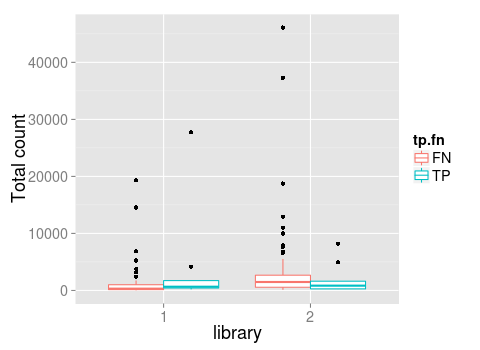

In [204]:
%%R -h 350
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(library, total_count, color=tp.fn)) +
    geom_boxplot() +
    labs(y='Total count') +
    theme(
        text = element_text(size=18)
        )  

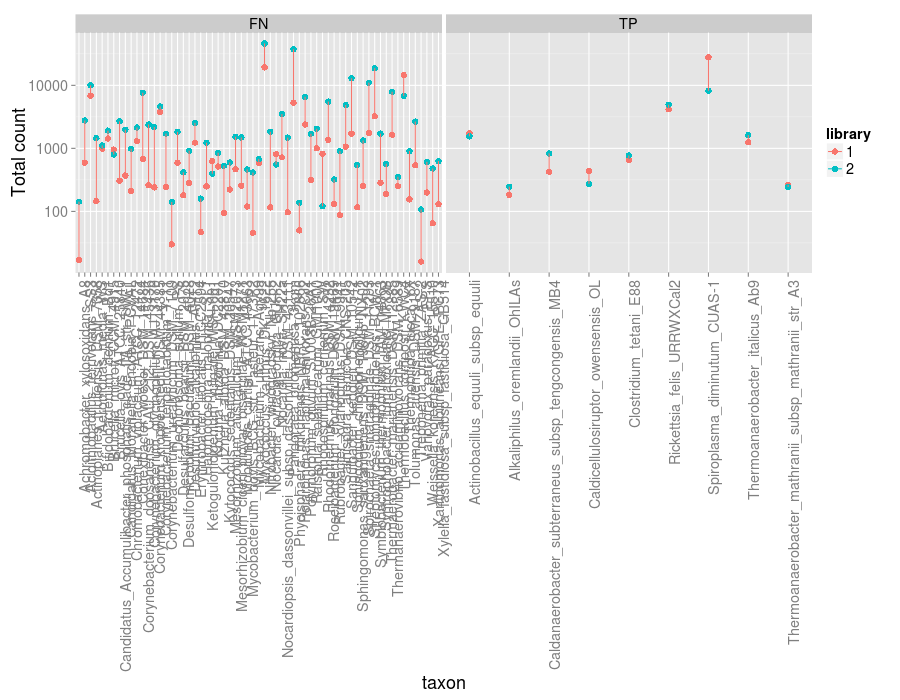

In [209]:
%%R -h 700 -w 900
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(taxon, total_count, group=taxon, color=library)) +
    geom_point(size=3) +
    geom_line() +
    scale_y_log10() +
    labs(y='Total count') +
    facet_grid(. ~ tp.fn, scales='free_x') +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)
        )  

__Notes:__

* FNs can be abundant
* __TP can have a lower abundance in the 'treatment' library__

### Just looking at the 'heavy' fractions

In [210]:
%%R
# OTU total counts

heavy.cut = 1.71

tbl.otu.sum = tbl.otu %>%
    filter(! grepl('inf', fraction)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min >= heavy.cut & BD_max <= 2) %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017           0
2       1       Acetobacterium_woodii_DSM_1030           0
3       1 Acetobacter_pasteurianus_IFO_3283-12         564
4       1    Acetohalobium_arabaticum_DSM_5501           0
5       1         Acholeplasma_laidlawii_PG-8A           0
6       1        Achromobacter_xylosoxidans_A8          17


In [211]:
%%R

tbl.tp.fn = inner_join(tbl.c.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                              taxon  BD_shift incorp.known  baseMean
1   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
2   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
3   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
4   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
5   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
6   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
  log2FoldChange    lfcSE       stat       pvalue       padj            p
1     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
2     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
3     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
4     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
5     5.33532814 1.665671 3.20311065 1.359517e-03 0.02434772 1.132750e

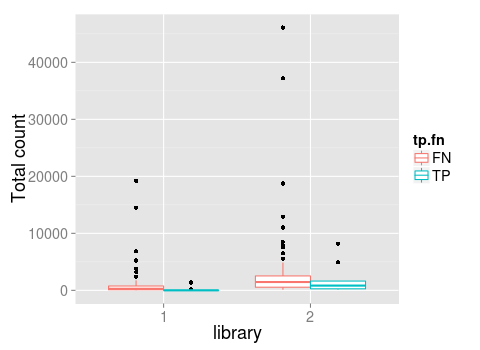

In [212]:
%%R -h 350
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(library, total_count, color=tp.fn)) +
    geom_boxplot() +
    labs(y='Total count') +
    theme(
        text = element_text(size=18)
        )  

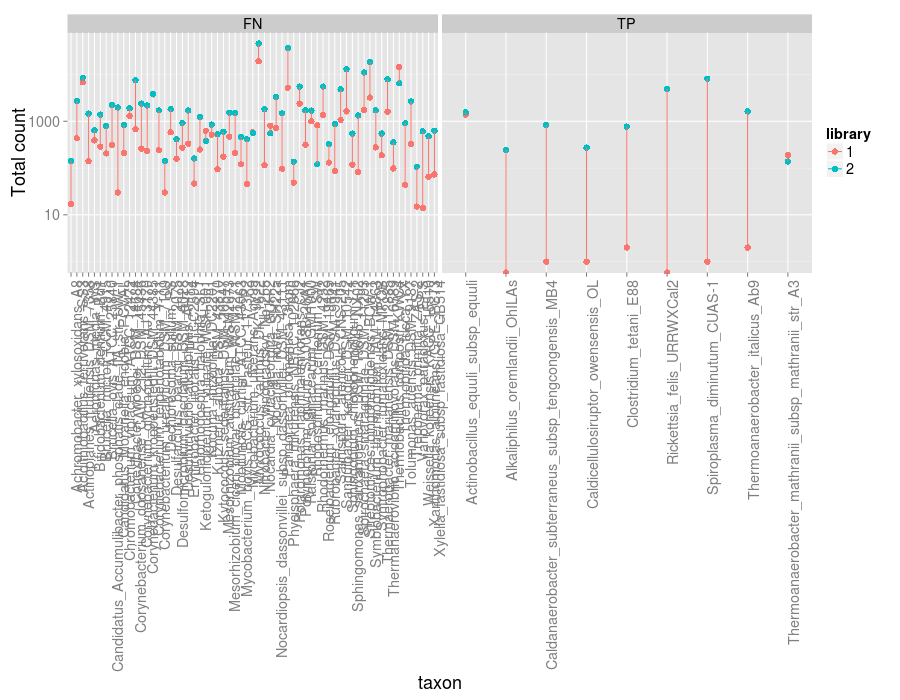

In [215]:
%%R -h 700 -w 900
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(taxon, total_count, group=taxon, color=library)) +
    geom_point(size=3) +
    geom_line() +
    scale_y_log10() +
    labs(y='Total count') +
    facet_grid(. ~ tp.fn, scales='free_x') +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)
        )  

In [ ]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
tbl.otu = read.delim('OTU_abs1e10.txt', sep='\t')

tbl.otu = tbl.otu %>% 
    filter(!grepl('inf', fraction, ignore.case=T)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%

tbl.j = inner_join(tbl.otu, tbl.ds, c('taxon' = 'taxon'))



__Notes:__

* The TPs (for the most part) are dramatically different in abundance between control and treatment

***

# Sandbox

In [73]:
# building tree structure
from os.path import abspath
nest = nestly.Nest()

##  values
vals = [str(x) for x in range(1,5)]
nest.add('vals', vals)


## input files
nest.add('--np', [1], create_dir=False)

buildDir = '/home/nick/t/nestly/' #os.path.join(workDir, 'vals')
nest.build(buildDir)

In [74]:
%%writefile /home/nick/t/example.sh
#!/bin/bash

export TIME='elapsed,maxmem,exitstatus\n%e,%M,%x'

echo {--np} > {--np}_test.txt

Writing /home/nick/t/example.sh


In [75]:
!cd /home/nick/t/; \
    chmod 777 example.sh 

In [76]:
!cd /home/nick/t/; \
    nestrun -j 2 --template-file example.sh -d nestly

2015-06-24 12:13:25,688 * INFO * Template: ./example.sh
2015-06-24 12:13:25,690 * INFO * [204263] Started ./example.sh in nestly/3
2015-06-24 12:13:25,692 * INFO * [204264] Started ./example.sh in nestly/2
2015-06-24 12:13:25,692 * INFO * [204263] nestly/3 Finished with 0
2015-06-24 12:13:25,694 * INFO * [204265] Started ./example.sh in nestly/1
2015-06-24 12:13:25,694 * INFO * [204264] nestly/2 Finished with 0
2015-06-24 12:13:25,696 * INFO * [204266] Started ./example.sh in nestly/4
2015-06-24 12:13:25,696 * INFO * [204265] nestly/1 Finished with 0
2015-06-24 12:13:25,696 * INFO * [204266] nestly/4 Finished with 0
